In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


# Load dataset
aug_train = pd.read_csv('aug_train.csv')
aug_test = pd.read_csv('aug_test.csv')
submission_df = pd.read_csv('sample_submission.csv')

# Cek bentuk data untuk memastikan file berhasil dibaca
print("Train shape:", aug_train.shape)
print("Test shape:", aug_test.shape)
print("Submission shape:", submission_df.shape)

# Opsional: lihat beberapa baris pertama
print(aug_train.head())

combined = pd.concat([aug_train.drop(columns=["target"]), aug_test], axis=0)

# Encode kolom kategori
label_encoders = {}
categorical_cols = combined.select_dtypes(include='object').columns
for col in categorical_cols:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col].astype(str))
    label_encoders[col] = le

aug_train_encoded = combined.iloc[:len(aug_train)].copy()
aug_test_encoded = combined.iloc[len(aug_train):].copy()
aug_train_encoded["target"] = aug_train["target"].values


Train shape: (19158, 14)
Test shape: (2129, 13)
Submission shape: (2129, 2)
   enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624    NaN   
3        33241  city_115                   0.789    NaN   
4          666  city_162                   0.767   Male   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   
3   No relevent experience                 NaN        Graduate   
4  Has relevent experience       no_enrollment         Masters   

  major_discipline experience company_size    company_type last_new_job  \
0             STEM        >20          NaN             NaN            1   
1             STEM    

A. Data Wrangling: Handling Missing Values, Duplicates, and Outliers
python


In [2]:
import pandas as pd
import numpy as np
from scipy import stats

# Cek missing values sebelum proses
print("Missing values before cleaning:")
print(aug_train_encoded.isnull().sum())

# Fill missing values for categorical columns
aug_train_encoded['gender'].fillna('Unknown', inplace=True)
aug_train_encoded['company_size'].fillna('Unknown', inplace=True)
aug_train_encoded['company_type'].fillna('Unknown', inplace=True)

# Fill missing values for numerical columns with median
aug_train_encoded['city_development_index'].fillna(aug_train_encoded['city_development_index'].median(), inplace=True)

# Handle duplicates
aug_train_encoded.drop_duplicates(inplace=True)

# Handle outliers using Z-Score (for numeric columns like 'training_hours')
aug_train_encoded = aug_train_encoded[(np.abs(stats.zscore(aug_train_encoded['training_hours'])) < 3)]

# Cek missing values setelah pembersihan
print("Missing values after cleaning:")
print(aug_train_encoded.isnull().sum())


Missing values before cleaning:
enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64
Missing values after cleaning:
enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64


C:\Users\affan\AppData\Local\Temp\ipykernel_60520\2705403384.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  aug_train_encoded['gender'].fillna('Unknown', inplace=True)
C:\Users\affan\AppData\Local\Temp\ipykernel_60520\2705403384.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

B. Feature Engineering: One-Hot Encoding, Scaling, and Feature Extraction
python


In [3]:
from sklearn.preprocessing import StandardScaler

# Copy dataframe agar tidak mengubah yang asli
df = aug_train.copy()

# Konversi kolom 'experience' menjadi numerik
def convert_experience(val):
    if val == '>20':
        return 21
    elif val == '<1':
        return 0
    elif pd.isnull(val) or val == 'null':
        return -1
    else:
        try:
            return int(val)
        except:
            return -1

df['experience'] = df['experience'].astype(str).apply(convert_experience)

# Drop kolom yang tidak bisa langsung digunakan (contohnya 'city')
df = df.drop(columns=['city'])

# One-Hot Encoding untuk fitur kategorikal
aug_train_encoded = pd.get_dummies(df, columns=[
    'gender', 'relevent_experience', 'enrolled_university',
    'education_level', 'major_discipline', 'company_size',
    'company_type', 'last_new_job'
], drop_first=True)

# Feature Scaling untuk fitur numerik
scaler = StandardScaler()
aug_train_encoded['city_development_index'] = scaler.fit_transform(aug_train_encoded[['city_development_index']])
aug_train_encoded['training_hours'] = scaler.fit_transform(aug_train_encoded[['training_hours']])

# Feature Extraction: kombinasi 'experience' dan 'city_development_index'
aug_train_encoded['exp_index'] = aug_train_encoded['experience'] * aug_train_encoded['city_development_index']


C. Data Visualization: EDA (Exploratory Data Analysis)
python

C:\Users\affan\AppData\Local\Temp\ipykernel_60520\3604513936.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=aug_train, palette='Set2')


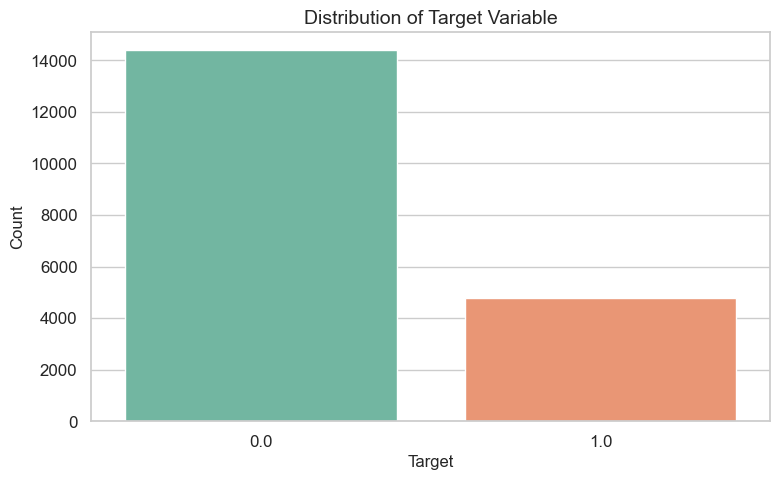

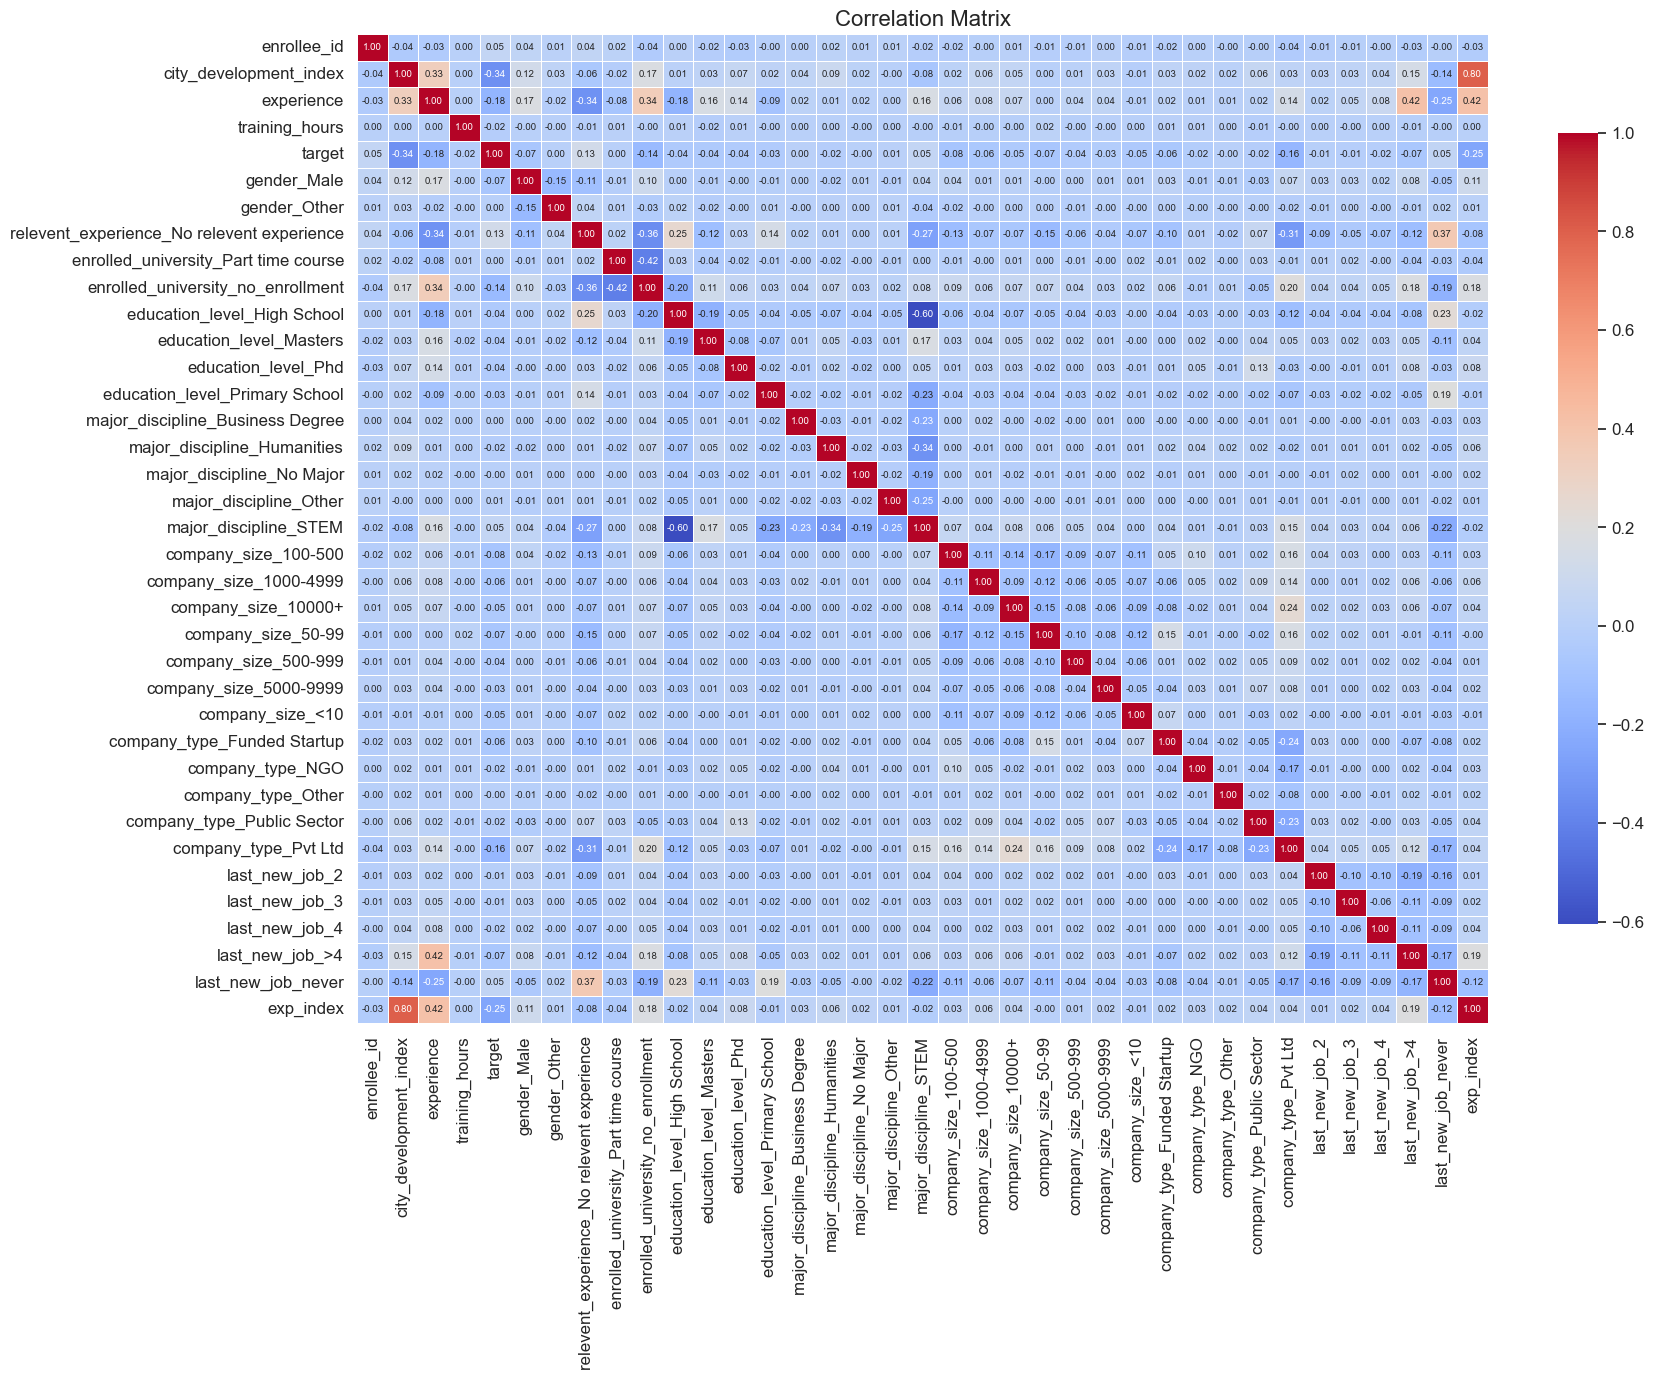

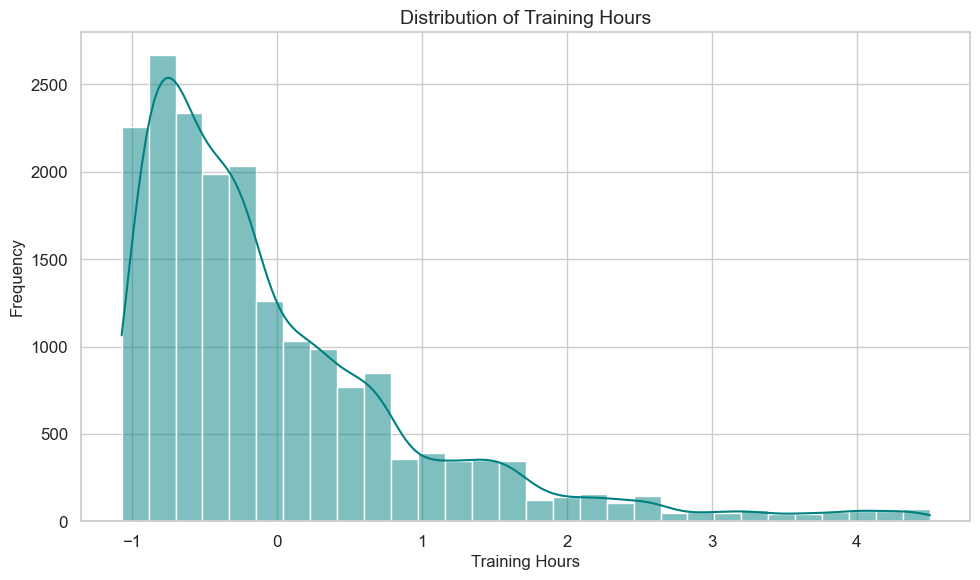

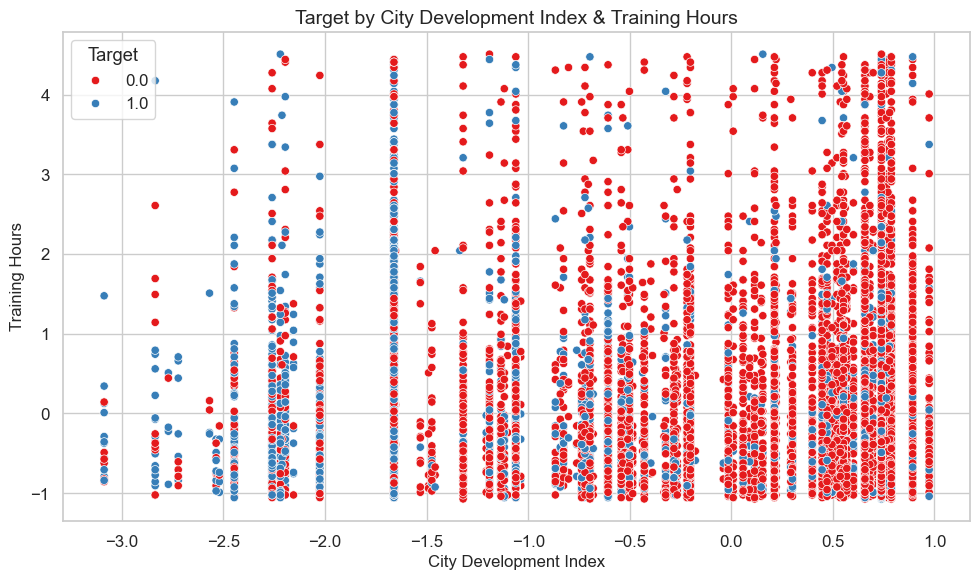

In [4]:
# Set default style and font scale for readability
sns.set(style="whitegrid", font_scale=1.1)

# Visualisasi distribusi variabel target
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=aug_train, palette='Set2')
plt.title('Distribution of Target Variable', fontsize=14)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

# Visualisasi correlation matrix
plt.figure(figsize=(18, 14))
correlation_matrix = aug_train_encoded.corr()

sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            annot_kws={"size": 7})

plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Distribusi 'training_hours'
plt.figure(figsize=(10, 6))
sns.histplot(aug_train_encoded['training_hours'], kde=True, color='teal', bins=30)
plt.title('Distribution of Training Hours', fontsize=14)
plt.xlabel('Training Hours', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

# Scatter plot berdasarkan 'city_development_index' dan 'training_hours' berwarna menurut 'target'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='city_development_index', y='training_hours', hue='target', palette='Set1', data=aug_train_encoded)
plt.title('Target by City Development Index & Training Hours', fontsize=14)
plt.xlabel('City Development Index', fontsize=12)
plt.ylabel('Training Hours', fontsize=12)
plt.legend(title='Target')
plt.tight_layout()
plt.show()
